In [1]:
#!pip install yfinance

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
# System Constants
Epoch_count = 50
Batch_size = 32

In [5]:
walmart_price_data = yf.Ticker("WMT")
walmart_historical_data = walmart_price_data.history(period="max")

In [6]:
#Having a look at the closing price data of the stocks
# Get closing price column from the dataframe
closing_price_walmart = walmart_historical_data.iloc[:,3:4]
closing_price_walmart = closing_price_walmart.rename(columns={"Close": "Closing Price"})
closing_price_walmart.head()

,Closing Price
Date,
1972-08-25 00:00:00-04:00,0.035475
1972-08-28 00:00:00-04:00,0.035341
1972-08-29 00:00:00-04:00,0.034938
1972-08-30 00:00:00-04:00,0.034938
1972-08-31 00:00:00-04:00,0.034400


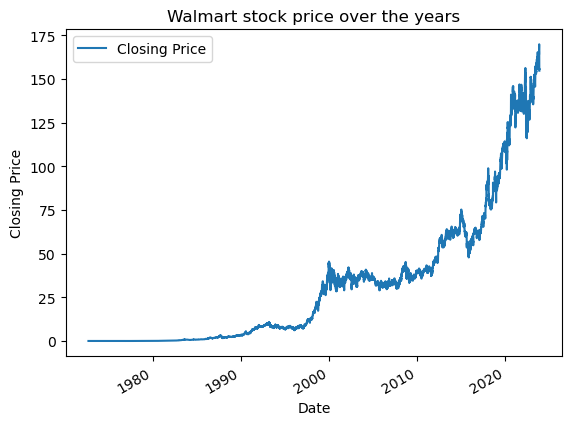

In [8]:
# Plotting the closing stock price data
closing_price_walmart.plot()
plt.ylabel("Closing Price")
plt.title("Walmart stock price over the years")
plt.show()

In [7]:
# Scale the data using Min-Max scaling to reduce computational cost.
scaler = MinMaxScaler()
closing_price_walmart_scaled = scaler.fit_transform(closing_price_walmart)

# The following logical comparison concludes that there are no NaN values.
len(closing_price_walmart.isna()) == len(closing_price_walmart)
closing_price_walmart_scaled_df = pd.DataFrame(closing_price_walmart_scaled)
closing_price_walmart_scaled_df.index = closing_price_walmart.index
closing_price_walmart_scaled_df = closing_price_walmart_scaled_df.rename(columns={0:"Closing Price"})
closing_price_walmart_scaled_df.head()

,Closing Price
Date,
1972-08-25 00:00:00-04:00,0.000158
1972-08-28 00:00:00-04:00,0.000157
1972-08-29 00:00:00-04:00,0.000155
1972-08-30 00:00:00-04:00,0.000155
1972-08-31 00:00:00-04:00,0.000152


In [8]:
def get_data_splits(data, train_size=20, label_count=1):
    
    # Initialize empty arrays for training sets and labels
    train_sets = np.empty((0, train_size))
    labels = np.empty((0, label_count))

    # Calculate the length of the input data
    length = len(data)

    # Iterate through the data to create training sets and labels
    for i in range(0, length):
        # Check if extending the current index by train_size exceeds the data length
        if (i + train_size) >= length:
            break

        # Append a reshaped training sequence to the train_sets array
        train_sequence = data[i:(i + train_size)].reshape(train_size,)
        train_sets = np.append(train_sets, [train_sequence], axis=0)

        # Append the corresponding label sequence to the labels array
        label_sequence = data[(i + train_size):(i + train_size + label_count)].reshape(label_count,)
        labels = np.append(labels, [label_sequence], axis=0)

    # Reshape the arrays for compatibility with machine learning models
    reshaped_train_sets = train_sets.reshape(len(train_sets), train_size, 1)
    reshaped_labels = labels.reshape(len(labels), label_count, 1)

    return reshaped_train_sets, reshaped_labels

In [9]:
# Splitting the dataset
length = len(closing_price_walmart_scaled)
train_sample_count = round(0.60 * length)
remaining_sample_count = length - train_sample_count
val_sample_count = round(0.50 * remaining_sample_count)

training_walmart = closing_price_walmart_scaled[0:train_sample_count]
validation_walmart = closing_price_walmart_scaled[train_sample_count:(
    train_sample_count + val_sample_count)]
testing_walmart = closing_price_walmart_scaled[(
    train_sample_count + val_sample_count):length]

In [10]:
len(training_walmart), len(validation_walmart), len(testing_walmart)

(7752, 2584, 2584)

In [11]:
# Get the train features, train labels, test features, test labels
train_size = 20
label_count = 1
X_train, y_train = get_data_splits(training_walmart, train_size, label_count)
X_val, y_val = get_data_splits(validation_walmart, train_size, label_count)
X_test, y_test = get_data_splits(testing_walmart, train_size, label_count)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

7732 7732
2564 2564
2564 2564


In [12]:
def plot_training_history_curve(fitted_model):
    """Plot training/validation loss and accuracy curve."""
    history_df = pd.DataFrame(fitted_model.history)
    history_df.plot()
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss - Accuracy")
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted_values(y_train, y_test, train_predict, test_predict):
    """Plot actual and predicted values."""
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)

    plt.figure(figsize=(15, 8), dpi=80)
    plt.plot(range(rows), actual, label='Actual')
    plt.plot(range(rows), predictions, label='Predictions')
    plt.axvline(x=len(y_train), color='r')
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Closing Stock price')
    plt.title('Actual and Predicted values with the red line separating Training And Test examples')
    plt.show()

### Vanilla RNN

In [13]:
def create_simple_rnn_model(hidden_units, dense_units, input_shape, activation, lr=0.001):
    """Create a vanilla Simple RNN model."""
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
    return model

# Define parameters
n_hidden_units = 64
n_dense_units = 1
input_shape = (train_size, 1)

# Create the Simple RNN model
simple_rnn_model = create_simple_rnn_model(
    hidden_units=n_hidden_units,
    dense_units=n_dense_units,
    input_shape=input_shape,
    activation='tanh',
    lr=0.001
)

In [14]:
# Create vanilla RNN model
vanilla_rnn = create_simple_rnn_model(n_hidden_units, n_dense_units, input_shape, activation='tanh')
vanilla_rnn.summary()

# Training the vanilla RNN
with tf.device('/cpu:0'):
    fitted_vanilla_rnn = vanilla_rnn.fit(
        X_train, y_train, validation_data=(X_val, y_val), batch_size=Batch_size, epochs=Epoch_count)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
242/242 [==============================] - 1s 2ms/step - loss: 2.3707e-04 - val_loss: 2.6199e-04
Epoch 2/50
242/242 [==============================] - 0s 1ms/step - loss: 2.1528e-05 - val_loss: 1.8335e-04
Epoch 3/50
242/242 [==============================] - 0s 1ms/step - loss: 1.7208e-05 - val_loss: 7.0068e-05
Epoch 4/50
242/242 [==============================] - 0s 1ms/step - loss: 1.5228e-05 - val_l

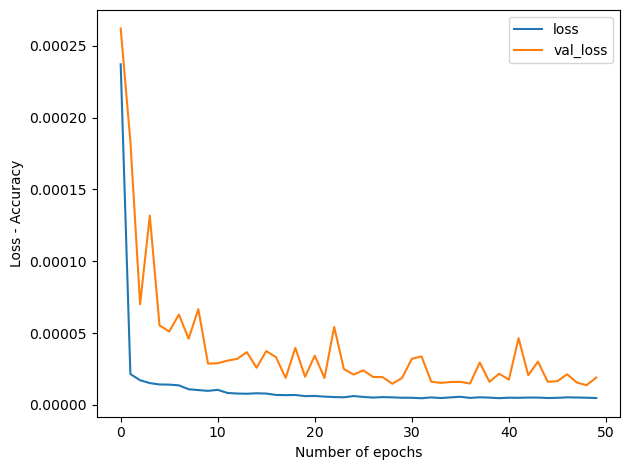

In [15]:
plot_training_history_curve(fitted_vanilla_rnn)

81/81 [==============================] - 0s 455us/step


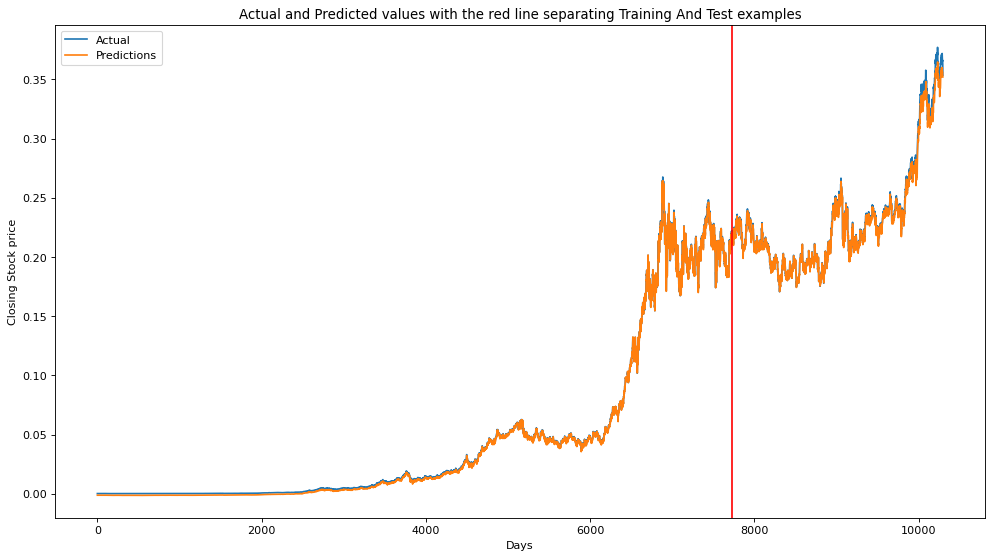

In [16]:
# Predictions using the trained vanilla RNN model
with tf.device('/cpu:0'):
    train_predictions_vanilla = fitted_vanilla_rnn.model.predict(X_train)
    val_predictions_vanilla = fitted_vanilla_rnn.model.predict(X_val)

# Plotting actual stock prices and predictions
plot_actual_vs_predicted_values(y_train, y_val, train_predictions_vanilla, val_predictions_vanilla)

### EXPERIMENTATION ON VANILLA RNN

In [17]:
# Creating RNN with multiple layers
def create_multi_layer_rnn(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    
    for i, units in enumerate(hidden_units_list):
        return_sequences = (i < len(hidden_units_list) - 1)
        model.add(SimpleRNN(units, input_shape=input_shape, activation=activation, return_sequences=return_sequences))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=lr))
    
    return model

# Define parameters
n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (train_size, 1)

# Create the multi-layer RNN model
multi_layer_rnn_model = create_multi_layer_rnn(
    hidden_units_list=n_hidden_units_list,
    dense_units=n_dense_units,
    input_shape=input_shape,
    activation='tanh',
    lr=0.001
)

In [18]:
# Create RNN with multiple layers
rnn_multi_layer = create_multi_layer_rnn(n_hidden_units_list, n_dense_units, input_shape, activation='tanh')
rnn_multi_layer.summary()

# Train the RNN with multiple SimpleRNN layers
with tf.device('/cpu:0'):
    fitted_rnn_multi_layer = rnn_multi_layer.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        batch_size=Batch_size, epochs=Epoch_count
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 20, 64)            4224      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 20, 64)            8256      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20801 (81.25 KB)
Trainable params: 20801 (81.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
242/242 [==============================] - 2s 4ms/step - loss: 0.0037 - val_loss: 3.6576e-04
Epoch 2/50
242/242 [==========================

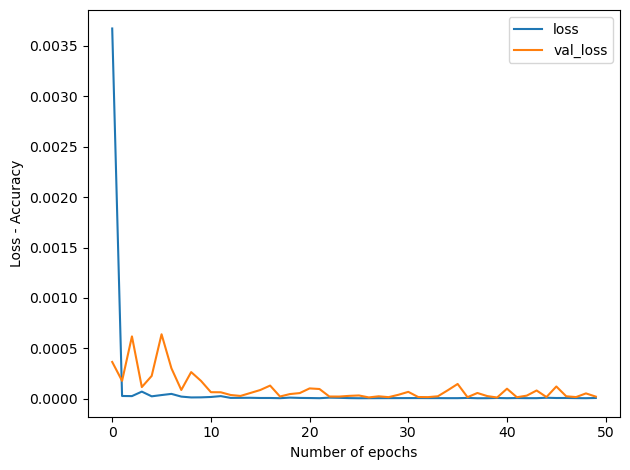

In [19]:
plot_training_history_curve(fitted_rnn_multi_layer)

81/81 [==============================] - 0s 1ms/step


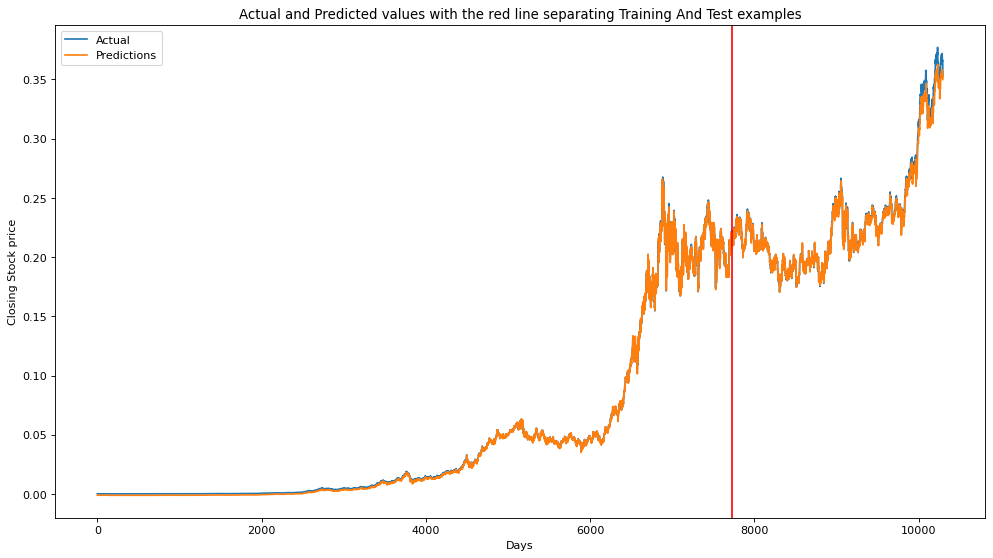

In [20]:
# Predictions using the trained RNN model
with tf.device('/cpu:0'):
    train_predictions_rnn_multi_layer = fitted_rnn_multi_layer.model.predict(X_train)
    val_predictions_rnn_multi_layer = fitted_rnn_multi_layer.model.predict(X_val)

# Plotting actual stock prices and predictions
plot_actual_vs_predicted_values(y_train, y_val, train_predictions_rnn_multi_layer, val_predictions_rnn_multi_layer)

### Experimenting with the activation function and learning rate scheduling techniques.

In [21]:
def create_rnn_experiment(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = keras.optimizers.legacy.Adam() if optimizer == "Adam" else keras.optimizers.legacy.RMSprop()

    model.compile(loss='mean_squared_error', optimizer=optimizing_function)
    return model

def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch / epochs_drop))

def exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k * epoch)

callbacks_decay = [
    keras.callbacks.LearningRateScheduler(step_decay, verbose=1),
    keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)
]
callback_decay_keys = ["constant", "step_decay", "exp_decay"]

initial_learning_rate = 0.01
time_decay = initial_learning_rate / Epoch_count

In [22]:
n_hidden_units = 64
n_dense_units = 1
results_vanilla = []
optimizers = ["Adam", "RMSProp"]

for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        model = create_rnn_experiment(n_hidden_units, n_dense_units, input_shape, activation='tanh', optimizer=optimizer)

        # Training the RNN with multiple SimpleRNN layers
        with tf.device('/cpu:0'):
            fitted_model = model.fit(
                X_train, y_train, validation_data=(X_val, y_val),
                batch_size=Batch_size, epochs=Epoch_count if i == 0 else Epoch_count,
                callbacks=[callbacks_decay[i - 1]] if i != 0 else None
            )

        predictions = fitted_model.model.predict(X_val)
        val_mse = mean_squared_error(y_val.reshape(y_val.shape[0], 1), predictions)
        results_vanilla.append((optimizer, callback_decay_keys[i], val_mse))

Epoch 1/50
242/242 [==============================] - 1s 2ms/step - loss: 1.5330e-04 - val_loss: 3.5489e-04
Epoch 2/50
242/242 [==============================] - 0s 1ms/step - loss: 1.6263e-05 - val_loss: 5.9479e-05
Epoch 3/50
242/242 [==============================] - 0s 1ms/step - loss: 1.2823e-05 - val_loss: 5.2917e-05
Epoch 4/50
242/242 [==============================] - 0s 1ms/step - loss: 1.1243e-05 - val_loss: 6.2374e-05
Epoch 5/50
242/242 [==============================] - 0s 1ms/step - loss: 8.7510e-06 - val_loss: 3.3913e-05
Epoch 6/50
242/242 [==============================] - 0s 1ms/step - loss: 8.8260e-06 - val_loss: 8.3112e-05
Epoch 7/50
242/242 [==============================] - 0s 1ms/step - loss: 7.8941e-06 - val_loss: 5.3309e-05
Epoch 8/50
242/242 [==============================] - 0s 1ms/step - loss: 8.4254e-06 - val_loss: 3.2817e-05
Epoch 9/50
242/242 [==============================] - 0s 1ms/step - loss: 6.4796e-06 - val_loss: 2.0639e-05
Epoch 10/50
242/242 [=======


Epoch 8: LearningRateScheduler setting learning rate to 0.004965853037914095.
Epoch 8/50
242/242 [==============================] - 0s 1ms/step - loss: 7.3986e-06 - val_loss: 7.5978e-05 - lr: 0.0050

Epoch 9: LearningRateScheduler setting learning rate to 0.004493289641172216.
Epoch 9/50
242/242 [==============================] - 0s 1ms/step - loss: 6.5675e-06 - val_loss: 2.5004e-05 - lr: 0.0045

Epoch 10: LearningRateScheduler setting learning rate to 0.004065696597405992.
Epoch 10/50
242/242 [==============================] - 0s 1ms/step - loss: 6.4299e-06 - val_loss: 2.0812e-05 - lr: 0.0041

Epoch 11: LearningRateScheduler setting learning rate to 0.0036787944117144234.
Epoch 11/50
242/242 [==============================] - 0s 1ms/step - loss: 5.8857e-06 - val_loss: 1.9035e-05 - lr: 0.0037

Epoch 12: LearningRateScheduler setting learning rate to 0.003328710836980796.
Epoch 12/50
242/242 [==============================] - 0s 1ms/step - loss: 6.4280e-06 - val_loss: 1.9048e-05 - lr: 


Epoch 48: LearningRateScheduler setting learning rate to 9.095277101695816e-05.
Epoch 48/50
242/242 [==============================] - 0s 1ms/step - loss: 4.0965e-06 - val_loss: 2.2127e-05 - lr: 9.0953e-05

Epoch 49: LearningRateScheduler setting learning rate to 8.229747049020023e-05.
Epoch 49/50
242/242 [==============================] - 0s 1ms/step - loss: 4.0842e-06 - val_loss: 1.6216e-05 - lr: 8.2297e-05

Epoch 50: LearningRateScheduler setting learning rate to 7.446583070924338e-05.
Epoch 50/50
81/81 [==============================] - 0s 470us/step
Epoch 1/50
242/242 [==============================] - 1s 1ms/step - loss: 3.9222e-04 - val_loss: 7.4505e-05
Epoch 2/50
242/242 [==============================] - 0s 1ms/step - loss: 5.0074e-05 - val_loss: 2.2252e-04
Epoch 3/50
242/242 [==============================] - 0s 1ms/step - loss: 2.9196e-05 - val_loss: 2.1369e-05
Epoch 4/50
242/242 [==============================] - 0s 1ms/step - loss: 2.0963e-05 - val_loss: 1.8990e-05
Epoch 

242/242 [==============================] - 0s 1ms/step - loss: 0.0390 - val_loss: 0.1443 - lr: 0.0061

Epoch 7: LearningRateScheduler setting learning rate to 0.005488116360940264.
Epoch 7/50
242/242 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.1031 - lr: 0.0055

Epoch 8: LearningRateScheduler setting learning rate to 0.004965853037914095.
Epoch 8/50
242/242 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0835 - lr: 0.0050

Epoch 9: LearningRateScheduler setting learning rate to 0.004493289641172216.
Epoch 9/50
242/242 [==============================] - 0s 1ms/step - loss: 0.0220 - val_loss: 0.0979 - lr: 0.0045

Epoch 10: LearningRateScheduler setting learning rate to 0.004065696597405992.
Epoch 10/50
242/242 [==============================] - 0s 1ms/step - loss: 0.0192 - val_loss: 0.0317 - lr: 0.0041

Epoch 11: LearningRateScheduler setting learning rate to 0.0036787944117144234.
Epoch 11/50
242/242 [==========================

In [23]:
columns = ["Optimizer", "Decay type", "Val MSE"]
results_dataframe = pd.DataFrame(results_vanilla, columns=columns)
results_dataframe

,Optimizer,Decay type,Val MSE
0,Adam,constant,0.000024
1,Adam,step_decay,0.000017
2,Adam,exp_decay,0.000022
3,RMSProp,constant,0.000018
4,RMSProp,step_decay,0.002659
5,RMSProp,exp_decay,0.005868


In [24]:
# Based on the above results, Adam with either of exp decay or constant learning rate is the best one

# Create RNN model with constant learning rate
optimized_rnn_constant_lr = create_rnn_experiment(n_hidden_units, n_dense_units, input_shape, activation='tanh', optimizer=keras.optimizers.legacy.Adam())
optimized_rnn_constant_lr.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=initial_learning_rate))

# Training the RNN model with constant learning rate
with tf.device('/cpu:0'):
    fitted_optimized_rnn_constant_lr = optimized_rnn_constant_lr.fit(X_train, y_train, validation_data=(X_val, y_val),
                                                                      batch_size=Batch_size, epochs=Epoch_count)


Epoch 1/50
242/242 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 1.4935e-04
Epoch 2/50
242/242 [==============================] - 0s 1ms/step - loss: 2.5326e-05 - val_loss: 1.4306e-04
Epoch 3/50
242/242 [==============================] - 0s 1ms/step - loss: 1.4371e-05 - val_loss: 6.4297e-05
Epoch 4/50
242/242 [==============================] - 0s 1ms/step - loss: 9.3691e-06 - val_loss: 2.5325e-05
Epoch 5/50
242/242 [==============================] - 0s 1ms/step - loss: 8.9936e-06 - val_loss: 3.4657e-05
Epoch 6/50
242/242 [==============================] - 0s 1ms/step - loss: 7.1518e-06 - val_loss: 1.9108e-05
Epoch 7/50
242/242 [==============================] - 0s 1ms/step - loss: 7.3963e-06 - val_loss: 2.1319e-05
Epoch 8/50
242/242 [==============================] - 0s 1ms/step - loss: 6.9730e-06 - val_loss: 2.0706e-05
Epoch 9/50
242/242 [==============================] - 0s 1ms/step - loss: 6.2513e-06 - val_loss: 3.7405e-05
Epoch 10/50
242/242 [===========

In [25]:
# Create an RNN model with Adam optimizer and constant learning rate
optimized_rnn_constant_lr = create_rnn_experiment(n_hidden_units, n_dense_units,
                                         input_shape, activation='tanh', 
                                         optimizer=keras.optimizers.legacy.Adam())

# Train the RNN model with constant learning rate
with tf.device('/cpu:0'):
    fitted_optimized_rnn_constant_lr = optimized_rnn_constant_lr.fit(X_train, y_train,
                                                                      validation_data=(X_val, y_val),
                                                                      batch_size=Batch_size, 
                                                                     epochs=Epoch_count)

Epoch 1/50
242/242 [==============================] - 1s 2ms/step - loss: 3.2532e-04 - val_loss: 5.7928e-04
Epoch 2/50
242/242 [==============================] - 0s 1ms/step - loss: 3.2352e-05 - val_loss: 6.4697e-05
Epoch 3/50
242/242 [==============================] - 0s 1ms/step - loss: 2.1075e-05 - val_loss: 2.3956e-05
Epoch 4/50
242/242 [==============================] - 0s 1ms/step - loss: 1.6376e-05 - val_loss: 2.0058e-05
Epoch 5/50
242/242 [==============================] - 0s 1ms/step - loss: 1.4392e-05 - val_loss: 9.1536e-05
Epoch 6/50
242/242 [==============================] - 0s 1ms/step - loss: 1.3346e-05 - val_loss: 3.8468e-05
Epoch 7/50
242/242 [==============================] - 0s 1ms/step - loss: 1.2642e-05 - val_loss: 1.6159e-05
Epoch 8/50
242/242 [==============================] - 0s 1ms/step - loss: 1.2144e-05 - val_loss: 4.5597e-05
Epoch 9/50
242/242 [==============================] - 0s 1ms/step - loss: 1.1523e-05 - val_loss: 6.7592e-05
Epoch 10/50
242/242 [=======

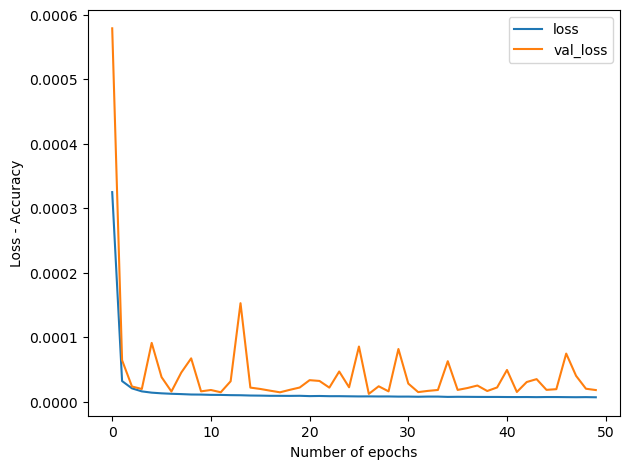

In [26]:
plot_training_history_curve(fitted_optimized_rnn_constant_lr)

81/81 [==============================] - 0s 464us/step


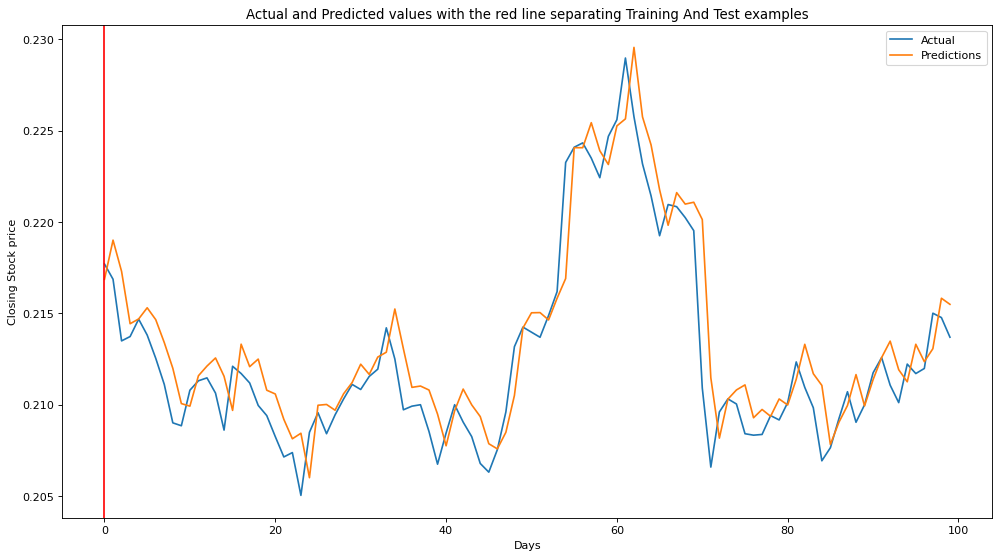

In [27]:
# Predictions using the trained RNN model
with tf.device('/cpu:0'):
    train_preds_optimized_rnn = fitted_optimized_rnn_constant_lr.model.predict(X_train)
    val_preds_optimized_rnn = fitted_optimized_rnn_constant_lr.model.predict(X_val)

plot_actual_vs_predicted_values(np.array([]), y_val[300:400], np.array([]),
            val_preds_optimized_rnn[300:400])

### Performance metrics

In [28]:
# Get training and validation MSEs for all variations of the RNN

# For vanilla RNN
train_mse_vanilla, val_mse_vanilla = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predictions_vanilla), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predictions_vanilla)

# For RNN with multiple layers
train_mse_rnn_multi_layer, val_mse_rnn_multi_layer = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predictions_rnn_multi_layer), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predictions_rnn_multi_layer)

# For RNN with optimized settings
train_mse_optimized_rnn, val_mse_optimized_rnn = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_preds_optimized_rnn), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_preds_optimized_rnn)

In [29]:
# Define a list of tuples for RNN summary
summary_list = [
    ("Vanilla RNN", train_mse_vanilla, val_mse_vanilla),
    ("Stacked RNN", train_mse_rnn_multi_layer, val_mse_rnn_multi_layer),
    ("Optimized Vanilla RNN", train_mse_optimized_rnn, val_mse_optimized_rnn)
]

# Create a DataFrame for RNN summary
summary_dataframe = pd.DataFrame(summary_list, columns=["Model", "Train MSE", "Val MSE"])
summary_dataframe

,Model,Train MSE,Val MSE
0,Vanilla RNN,0.000005,0.000019
1,Stacked RNN,0.000005,0.000022
2,Optimized Vanilla RNN,0.000005,0.000018


### Experimentation with window sizes

Train Data Shape: (7702, 50, 1) Train Labels Shape: (7702, 1, 1)
Validation Data Shape: (2534, 50, 1) Validation Labels Shape: (2534, 1, 1)
Epoch 1/50
241/241 [==============================] - 3s 10ms/step - loss: 0.0033 - val_loss: 5.4708e-04
Epoch 2/50
241/241 [==============================] - 2s 10ms/step - loss: 4.9327e-05 - val_loss: 3.3264e-04
Epoch 3/50
241/241 [==============================] - 2s 10ms/step - loss: 6.6507e-05 - val_loss: 5.1869e-04
Epoch 4/50
241/241 [==============================] - 2s 10ms/step - loss: 3.8816e-05 - val_loss: 1.8619e-04
Epoch 5/50
241/241 [==============================] - 2s 10ms/step - loss: 6.1190e-05 - val_loss: 1.8978e-04
Epoch 6/50
241/241 [==============================] - 2s 10ms/step - loss: 1.2501e-04 - val_loss: 2.0092e-04
Epoch 7/50
241/241 [==============================] - 2s 10ms/step - loss: 4.6362e-05 - val_loss: 3.4215e-04
Epoch 8/50
241/241 [==============================] - 2s 10ms/step - loss: 3.5747e-05 - val_loss: 1.6

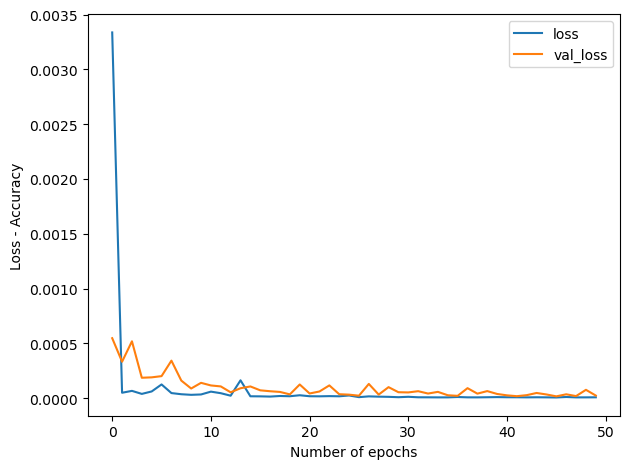

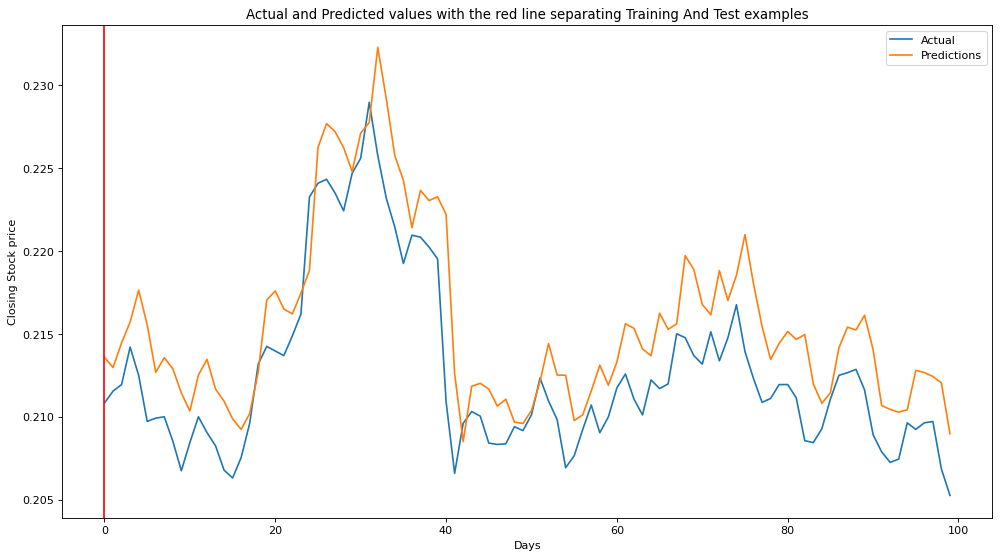

Val MSE = 2.3586331349052523e-05
Train Data Shape: (7652, 100, 1) Train Labels Shape: (7652, 1, 1)
Validation Data Shape: (2484, 100, 1) Validation Labels Shape: (2484, 1, 1)
Epoch 1/50
240/240 [==============================] - 5s 19ms/step - loss: 0.0021 - val_loss: 1.6966e-04
Epoch 2/50
240/240 [==============================] - 5s 19ms/step - loss: 1.1789e-04 - val_loss: 5.3722e-04
Epoch 3/50
240/240 [==============================] - 5s 19ms/step - loss: 8.5998e-05 - val_loss: 2.6478e-04
Epoch 4/50
240/240 [==============================] - 5s 19ms/step - loss: 1.0590e-04 - val_loss: 9.5681e-05
Epoch 5/50
240/240 [==============================] - 5s 19ms/step - loss: 6.3880e-05 - val_loss: 9.4037e-05
Epoch 6/50
240/240 [==============================] - 5s 19ms/step - loss: 7.6796e-05 - val_loss: 1.1628e-04
Epoch 7/50
240/240 [==============================] - 5s 19ms/step - loss: 6.7549e-05 - val_loss: 9.3119e-05
Epoch 8/50
240/240 [==============================] - 5s 19ms/step

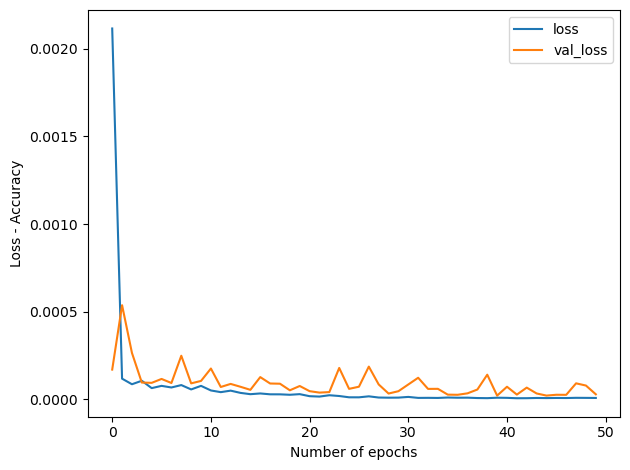

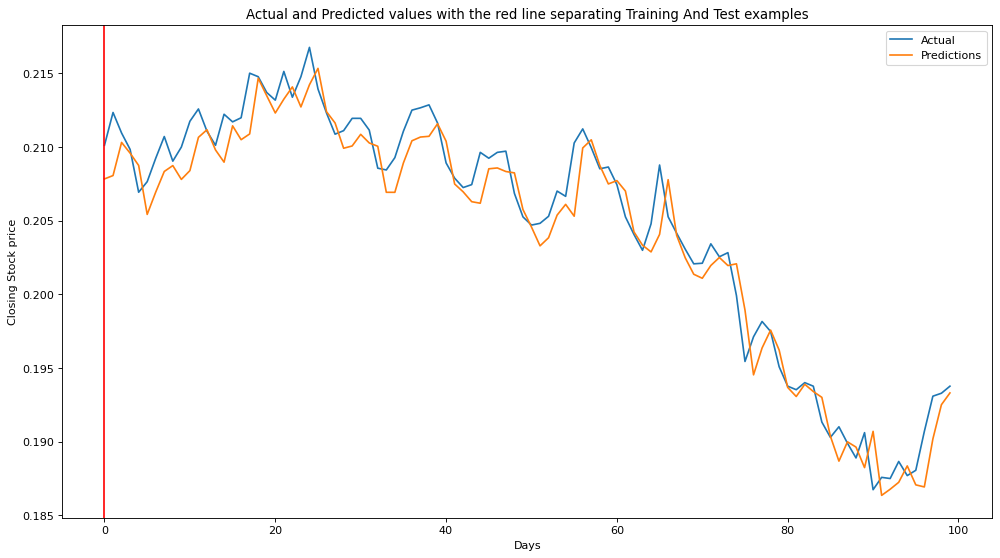

Val MSE = 2.8578980781147124e-05


In [33]:
train_sizes = [50, 100]
label_count = 1

for train_size in train_sizes:
    # Get train and validation data splits
    X_train_e, y_train_e = get_data_splits(training_walmart, train_size, label_count)
    X_val_e, y_val_e = get_data_splits(validation_walmart, train_size, label_count)

    # Display data shapes
    print("Train Data Shape:", X_train_e.shape, "Train Labels Shape:", y_train_e.shape)
    print("Validation Data Shape:", X_val_e.shape, "Validation Labels Shape:", y_val_e.shape)

    # Create and train RNN model
    model = create_multi_layer_rnn([n_hidden_units, n_hidden_units, n_hidden_units], n_dense_units,
                         (train_size, 1), activation='tanh')

    with tf.device('/cpu:0'):
        # Train the model
        fitted_model = model.fit(X_train_e, y_train_e, validation_data=(X_val_e, y_val_e),
                                 batch_size=Batch_size, epochs=Epoch_count)

        # Predictions on train and validation data
        train_predict = fitted_model.model.predict(X_train_e)
        val_predict = fitted_model.model.predict(X_val_e)

    # Plotting training history
    plot_training_history_curve(fitted_model)

    # Plotting actual stock prices and predictions for a subset
    plot_actual_vs_predicted_values(np.array([]), y_val_e[300:400], np.array([]), val_predict[300:400])

    # Calculate and display validation MSE
    val_mse = mean_squared_error(y_val_e.reshape(y_val_e.shape[0], 1), val_predict)
    print("Val MSE =", val_mse)